# 0. Library Import

In [1]:
# 라이브러리 import 시 opencv 관련 에러가 난다면 아래 코드 실행하기
# pip install opencv-python

In [2]:
# 기본 라이브러리
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import os

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 이미지 전처리
import cv2
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 모델링
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Flatten, Dropout
from keras import metrics

# 사전학습모델
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B2

# 모델 평가
from sklearn.metrics import f1_score

# 하이퍼파라미터 튜닝
from kerastuner.tuners import BayesianOptimization

# 모델 불러오기
from keras.models import save_model

# tensorflow 버전 확인
tf.__version__

C:\Users\octob\AppData\Local\Temp\ipykernel_24136\1712922449.py:30: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization


'2.12.0'

In [3]:
# Seed 고정
random.seed(1)
np.random.seed(1)
os.environ["PYTHONHASHSEED"] = str(1)
os.environ['TF_DETERMINISTIC_OPS'] = str(1)
tf.random.set_seed(1)

In [4]:
# 소수점 4자리까지 보이도록 설정
pd.set_option('display.float_format', '{:,.4f}'.format)

# 1. Preprocessing

## 1.1 Data Split (Train / Val / Test)

In [5]:
# train, val, test 세개로 쪼갠 폴더 만들기
# splitfolders.ratio('data/train', output='data_splited', seed=42, ratio=(.8, .1, .1))

## 1.2 Preprocessing using Image Generator

In [86]:
# 이미지 전처리 및 불러오기 (CNN에 맞춘 픽셀값)

# training set preprocessing
training_gen64 = ImageDataGenerator(rescale=1./255,
                                    rotation_range=7,
                                    horizontal_flip=True,
                                    zoom_range=0.2)

train_64 = training_gen64.flow_from_directory('data_splited/train',
                                                    target_size = (64, 64),
                                                    batch_size = 8,
                                                    class_mode = 'sparse',
                                                    shuffle = True)

# val set preprocessing
val_gen64 = ImageDataGenerator(rescale=1./255)
val_64 = val_gen64.flow_from_directory('data_splited/val',
                                        target_size = (64, 64),
                                        batch_size = 8,
                                        class_mode = 'sparse',
                                        shuffle = False)

Found 2759 images belonging to 19 classes.
Found 338 images belonging to 19 classes.


## 1.3 Target Class

In [7]:
# 타겟 클래스가 어떻게 설정되었나 살펴보기
train_64.class_indices

{'가구수정': 0,
 '걸레받이수정': 1,
 '곰팡이': 2,
 '꼬임': 3,
 '녹오염': 4,
 '들뜸': 5,
 '면불량': 6,
 '몰딩수정': 7,
 '반점': 8,
 '석고수정': 9,
 '오염': 10,
 '오타공': 11,
 '울음': 12,
 '이음부불량': 13,
 '창틀,문틀수정': 14,
 '터짐': 15,
 '틈새과다': 16,
 '피스': 17,
 '훼손': 18}

In [10]:
# 클래스 이름 목록
key_list = train_64.class_indices.keys()

# 클래스별 데이터 갯수 목록
unique, counts = np.unique(train_64.classes, return_counts = True)
uniq_dict = dict(zip(unique, counts))
value_list = uniq_dict.values()

# 클래스 이름과 데이터 갯수가 명시된 dictionary 만들기
dictionary = dict(zip(key_list, value_list))
print(dictionary)

{'가구수정': 9, '걸레받이수정': 245, '곰팡이': 116, '꼬임': 168, '녹오염': 11, '들뜸': 43, '면불량': 79, '몰딩수정': 104, '반점': 2, '석고수정': 45, '오염': 476, '오타공': 113, '울음': 17, '이음부불량': 13, '창틀,문틀수정': 21, '터짐': 129, '틈새과다': 4, '피스': 40, '훼손': 1124}


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 [Text(0, 0, '가구수정'),
  Text(1, 0, '걸레받이수정'),
  Text(2, 0, '곰팡이'),
  Text(3, 0, '꼬임'),
  Text(4, 0, '녹오염'),
  Text(5, 0, '들뜸'),
  Text(6, 0, '면불량'),
  Text(7, 0, '몰딩수정'),
  Text(8, 0, '반점'),
  Text(9, 0, '석고수정'),
  Text(10, 0, '오염'),
  Text(11, 0, '오타공'),
  Text(12, 0, '울음'),
  Text(13, 0, '이음부불량'),
  Text(14, 0, '창틀,문틀수정'),
  Text(15, 0, '터짐'),
  Text(16, 0, '틈새과다'),
  Text(17, 0, '피스'),
  Text(18, 0, '훼손')])

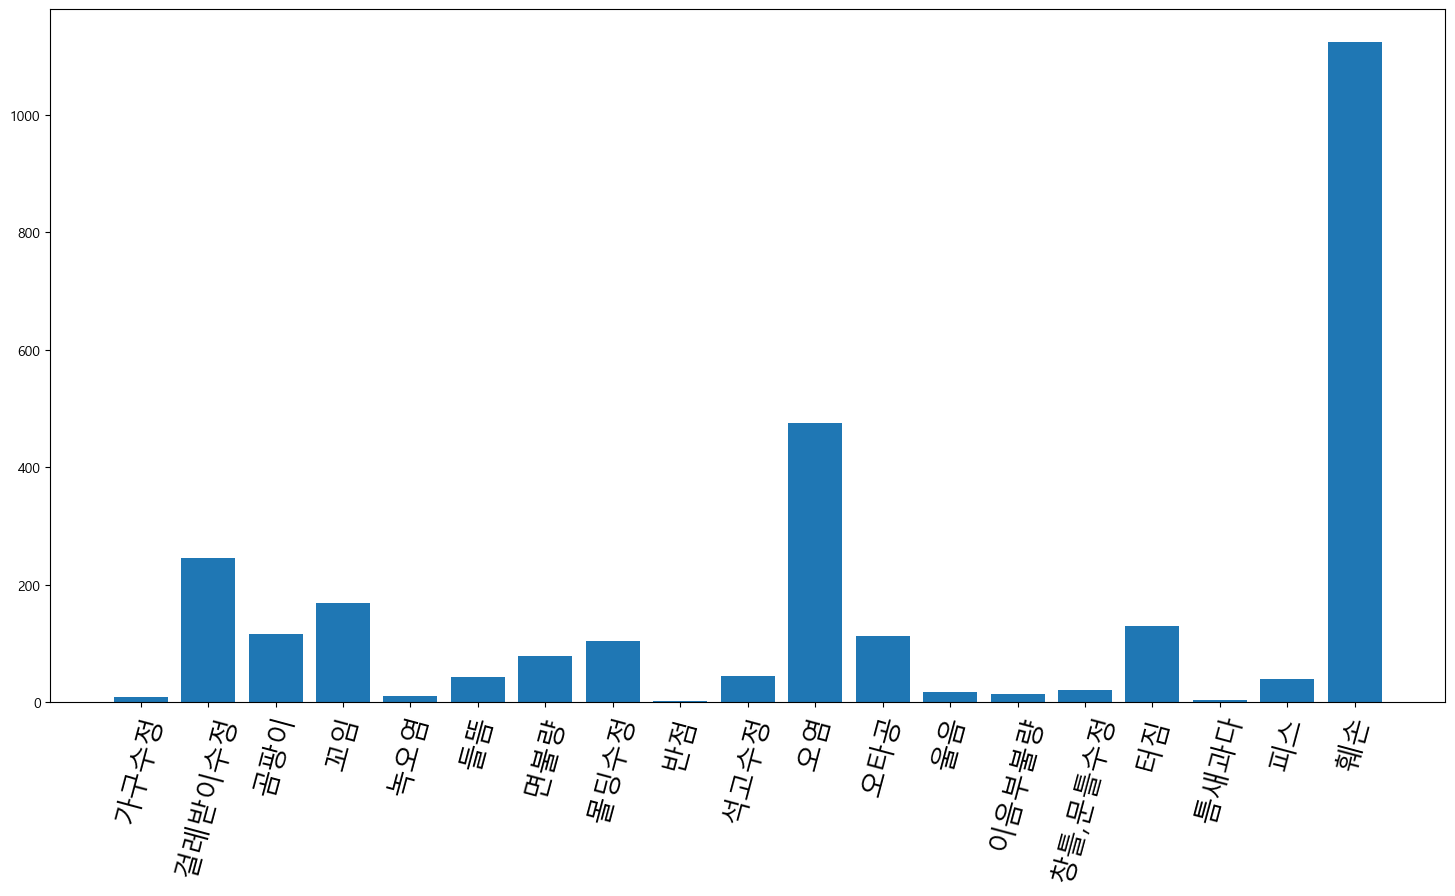

In [14]:
# # 한글 폰트 사용을 위해서 세팅
import matplotlib
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

# 클래스 별 데이터 갯수 시각화
plt.figure(figsize=(18, 9))
plt.bar(dictionary.keys(), dictionary.values())
plt.xticks(fontsize=20, rotation=75)

# 한눈에 보아도 불균형이 심하다

In [15]:
# 클래스당 평균 데이터 갯수는?
average = sum(dictionary.values()) / len(dictionary)
average

145.21052631578948

# 2. 모델 선정

## 2.1 CNN

In [16]:
# Custom CNN 만들기

cnn = Sequential()
cnn.add(Conv2D(32, (3,3), input_shape = (64,64,3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(32, (3,3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(32, (3,3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(Dense(units = 3137, activation='relu'))
cnn.add(Dense(units = 3137, activation='relu'))
cnn.add(Dense(units = 19, activation='softmax'))

In [17]:
# compile
cnn.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = [metrics.sparse_categorical_accuracy])

In [18]:
# early stopping을 이용한 모델 학습

checkpoint_filepath = "CNNbest.hdf5" # 가중치 저장할 경로 지정

# early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# best model 저장
save_best = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch', options=None)

# 학습
results = cnn.fit(x = train_64, validation_data = val_64, 
                  batch_size=8, epochs=100, verbose=1,
                  callbacks = [early_stop, save_best])


# 1 epoch 학습 : 70초 / 전체 학습 시간 : 40분

Epoch 1/100
345/345 [==============================] - ETA: 0s - loss: 2.0958 - sparse_categorical_accuracy: 0.4063
Epoch 1: val_loss improved from inf to 2.00679, saving model to CNNbest.hdf5
345/345 [==============================] - 114s 327ms/step - loss: 2.0958 - sparse_categorical_accuracy: 0.4063 - val_loss: 2.0068 - val_sparse_categorical_accuracy: 0.4142
Epoch 2/100
345/345 [==============================] - ETA: 0s - loss: 2.0654 - sparse_categorical_accuracy: 0.4070
Epoch 2: val_loss did not improve from 2.00679
345/345 [==============================] - 74s 214ms/step - loss: 2.0654 - sparse_categorical_accuracy: 0.4070 - val_loss: 2.0086 - val_sparse_categorical_accuracy: 0.4142
Epoch 3/100
345/345 [==============================] - ETA: 0s - loss: 2.0510 - sparse_categorical_accuracy: 0.4074
Epoch 3: val_loss improved from 2.00679 to 2.00419, saving model to CNNbest.hdf5
345/345 [==============================] - 69s 200ms/step - loss: 2.0510 - sparse_categorical_accuracy

In [94]:
# 모델별 평가지표 비교를 위한 Dataframe과 함수 만들기

eval_table = pd.DataFrame(index=['Loss', 'Accuracy', 'Weighted F1'], 
                          columns=['Custom CNN', 'ResNet', 'EfficientNet'])

# evaluate the model
def model_score(model, val_dataset, column):
    
    predictions = model.predict(val_dataset)
    predictions = np.argmax(predictions, axis = 1) # prediction 구할 시에 이 과정이 꼭 필요하다
    f1 = f1_score(val_dataset.classes, predictions, average = 'weighted')
    
    loss, accuracy = model.evaluate(val_dataset, verbose=0)
    eval_table[column] = [loss, accuracy, f1] 

    return eval_table

In [95]:
# 모델별 평가
model_score(cnn, val_64, 'Custom CNN')

43/43 [==============================] - 3s 75ms/step


,Custom CNN,ResNet,EfficientNet
Loss,2.0959,NaN,NaN
Accuracy,0.4290,NaN,NaN
Weighted F1,0.3999,NaN,NaN


## 2.2 ResNet50V2

In [11]:
# ResNet의 올바른 input_shape 224*224
# 이미지 불러오고 원하는 픽셀값으로 전처리

# training set preprocessing
training_gen224 = ImageDataGenerator(rescale=1./255,
                                     rotation_range=7,
                                     horizontal_flip=True,
                                     zoom_range=0.2)

train_224 = training_gen224.flow_from_directory('data_splited/train',
                                                    target_size = (224, 224),
                                                    batch_size = 32,
                                                    class_mode = 'sparse',
                                                    shuffle = True)

# val set preprocessing
val_gen224 = ImageDataGenerator(rescale=1./255)
val_224 = val_gen224.flow_from_directory('data_splited/val',
                                             target_size = (224, 224),
                                             batch_size = 32,
                                             class_mode = 'sparse',
                                             shuffle = True)

Found 2759 images belonging to 19 classes.
Found 338 images belonging to 19 classes.


In [22]:
# ResNet50 모델 불러오기
# include_top=False : 사전학습된 가중치를 사용하되 마지막엔 coustom dense layer를 만들기 위해 설정
resnet = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

In [23]:
# Freezing resnet layers
for layer in resnet.layers:
  layer.trainable = False

In [24]:
# resnet 모델의 끝부분에 추가할 custom layer 작성 
res_layer = resnet.output 
res_layer = GlobalAveragePooling2D()(res_layer) # 가장 마지막층의 shape인 행렬을 벡터화
res_layer = Dense(units = 1025, activation='relu')(res_layer)
res_layer = Dropout(rate = 0.2)(res_layer)
res_layer = Dense(units = 1025, activation='relu')(res_layer)
res_layer = Dropout(rate = 0.2)(res_layer)
res_layer = Dense(19, activation='softmax')(res_layer)

In [25]:
# resnet 모델에 custom layer 연결
resnet_customed = Model(inputs = resnet.input, outputs = res_layer)

In [26]:
# compile
resnet_customed.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = [metrics.sparse_categorical_accuracy])

In [27]:
# early stopping을 이용한 모델 학습 

checkpoint_filepath = "ResNetbest.hdf5" # 가중치 저장할 경로 지정

# early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# best model 저장
save_best = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch', options=None)

# 학습
results = resnet_customed.fit(x = train_224, validation_data = val_224, 
                  batch_size=32, epochs=100, verbose=1,
                  callbacks = [early_stop, save_best])

# 1 epoch 학습 : 2분 / 전체 학습 시간 : 28분

Epoch 1/100
173/173 [==============================] - ETA: 0s - loss: 1.4208 - sparse_categorical_accuracy: 0.5730
Epoch 1: val_loss improved from inf to 1.09693, saving model to ResNetbest.hdf5
173/173 [==============================] - 144s 814ms/step - loss: 1.4208 - sparse_categorical_accuracy: 0.5730 - val_loss: 1.0969 - val_sparse_categorical_accuracy: 0.6479
Epoch 2/100
173/173 [==============================] - ETA: 0s - loss: 1.0176 - sparse_categorical_accuracy: 0.6597
Epoch 2: val_loss improved from 1.09693 to 1.05935, saving model to ResNetbest.hdf5
173/173 [==============================] - 137s 793ms/step - loss: 1.0176 - sparse_categorical_accuracy: 0.6597 - val_loss: 1.0593 - val_sparse_categorical_accuracy: 0.6538
Epoch 3/100
173/173 [==============================] - ETA: 0s - loss: 0.8730 - sparse_categorical_accuracy: 0.7100
Epoch 3: val_loss did not improve from 1.05935
173/173 [==============================] - 137s 791ms/step - loss: 0.8730 - sparse_categorical_

In [96]:
# 모델별 평가
model_score(resnet_customed, val_224, 'ResNet')

22/22 [==============================] - 13s 559ms/step


,Custom CNN,ResNet,EfficientNet
Loss,2.0959,2.0594,NaN
Accuracy,0.4290,0.7988,NaN
Weighted F1,0.3999,0.2321,NaN


## 2.3 EfficientNetV2B3

In [38]:
# 해당 사전모델의 권장 input_shape은 300*300
# 이미지 불러와 원하는 픽셀값으로 전처리

# training set preprocessing
training_gen300 = ImageDataGenerator(rescale=1./255,
                                     rotation_range=7,
                                     horizontal_flip=True,
                                     zoom_range=0.2)

train_300 = training_gen300.flow_from_directory('data_splited/train',
                                                    target_size = (300, 300),
                                                    batch_size = 15,
                                                    class_mode = 'sparse',
                                                    shuffle = True)

# val set preprocessing
val_gen300 = ImageDataGenerator(rescale=1./255)
val_300 = val_gen300.flow_from_directory('data_splited/val',
                                             target_size = (300, 300),
                                             batch_size = 15,
                                             class_mode = 'sparse',
                                             shuffle = True)

Found 2759 images belonging to 19 classes.
Found 338 images belonging to 19 classes.


In [39]:
# EfficientNetV2B3 모델 불러오기
effinet = EfficientNetV2B2(include_top=False, weights='imagenet', input_shape=(300, 300, 3))

35839040/35839040 [==============================] - 3s 0us/step


In [40]:
# Freezing effinet layers
for layer in effinet.layers:
  layer.trainable = False

In [41]:
# effinet 모델의 끝부분에 추가할 custom layer 작성 
effi_layer = GlobalAveragePooling2D()(effinet.output)
effi_layer = Dense(units=1024, activation='relu')(effi_layer)
effi_layer = Dropout(rate=0.5)(effi_layer)
effi_layer = Dense(units=512, activation='relu')(effi_layer)
effi_layer = Dropout(rate=0.5)(effi_layer)
output = Dense(19, activation='softmax')(effi_layer)

In [42]:
# effinet 모델에 custom layer 연결
effinet_customed = Model(inputs = effinet.input, outputs = effi_layer)

In [43]:
# compile 
effinet_customed.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = [metrics.sparse_categorical_accuracy])

In [44]:
# early stopping 이용한 모델 학습

checkpoint_filepath = "EffiNetbest.hdf5" # 가중치 저장을 위한 경로 지정

# early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# best model 저장
save_best = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch', options=None)

# 학습
results = effinet_customed.fit(x = train_300, validation_data = val_300, 
                  batch_size=15, epochs=100, verbose=1,
                  callbacks = [early_stop, save_best])

# 1 epoch 학습 : 3분 / 전체 학습 시간 : 33분

Epoch 1/100
184/184 [==============================] - ETA: 0s - loss: 8.9321 - sparse_categorical_accuracy: 0.2120
Epoch 1: val_loss improved from inf to 9.44201, saving model to EffiNetbest.hdf5
184/184 [==============================] - 211s 1s/step - loss: 8.9321 - sparse_categorical_accuracy: 0.2120 - val_loss: 9.4420 - val_sparse_categorical_accuracy: 0.4142
Epoch 2/100
184/184 [==============================] - ETA: 0s - loss: 8.1715 - sparse_categorical_accuracy: 0.1964
Epoch 2: val_loss did not improve from 9.44201
184/184 [==============================] - 201s 1s/step - loss: 8.1715 - sparse_categorical_accuracy: 0.1964 - val_loss: 9.4420 - val_sparse_categorical_accuracy: 0.4142
Epoch 3/100
184/184 [==============================] - ETA: 0s - loss: 8.2072 - sparse_categorical_accuracy: 0.1986
Epoch 3: val_loss did not improve from 9.44201
184/184 [==============================] - 197s 1s/step - loss: 8.2072 - sparse_categorical_accuracy: 0.1986 - val_loss: 9.4420 - val_spa

In [97]:
# 모델별 평가
model_score(effinet_customed, val_300, 'EfficientNet')

23/23 [==============================] - 18s 709ms/step


,Custom CNN,ResNet,EfficientNet
Loss,2.0959,2.0594,9.4420
Accuracy,0.4290,0.7988,0.4142
Weighted F1,0.3999,0.2321,0.2426


# 3. Fine Tuning

In [46]:
# unfreezing resnet
resnet.trainable = True

In [47]:
# resnet 레이어 수 확인
len(resnet.layers)

190

In [48]:
# 처음 160개 모델까지 freeze, 161번부터 나머지 모델은 unfreeze
for layer in resnet.layers[:160]:
  layer.trainable = False

In [49]:
# compile 
resnet_customed.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = [metrics.sparse_categorical_accuracy])

In [50]:
# finetuning에서도 early stopping 학습 적용

checkpoint_filepath = "ResNetbest_finetuning.hdf5" # 가중치 저장을 위한 경로 지정

# early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# best model 저장
save_best = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch', options=None)

# 학습
results = resnet_customed.fit(x = train_224, validation_data = val_224, 
                  batch_size=16, epochs=100, verbose=1,
                  callbacks = [early_stop, save_best])

# 1 epoch 학습 : 3분 30초 / 전체 학습 시간 : 1시간 10분

Epoch 1/100
173/173 [==============================] - ETA: 0s - loss: 1.4482 - sparse_categorical_accuracy: 0.5640
Epoch 1: val_loss improved from inf to 2.14326, saving model to ResNetbest_finetuning.hdf5
173/173 [==============================] - 217s 1s/step - loss: 1.4482 - sparse_categorical_accuracy: 0.5640 - val_loss: 2.1433 - val_sparse_categorical_accuracy: 0.5947
Epoch 2/100
173/173 [==============================] - ETA: 0s - loss: 1.0700 - sparse_categorical_accuracy: 0.6680
Epoch 2: val_loss improved from 2.14326 to 1.30570, saving model to ResNetbest_finetuning.hdf5
173/173 [==============================] - 215s 1s/step - loss: 1.0700 - sparse_categorical_accuracy: 0.6680 - val_loss: 1.3057 - val_sparse_categorical_accuracy: 0.5769
Epoch 3/100
173/173 [==============================] - ETA: 0s - loss: 0.8803 - sparse_categorical_accuracy: 0.7202
Epoch 3: val_loss did not improve from 1.30570
173/173 [==============================] - 201s 1s/step - loss: 0.8803 - sparse

# 4. Hyperparameter Tuning

In [54]:
# 하이퍼파라미터 탐색을 위한 함수 지정
def build_hypermodel(hp):
    
    # set the learning rate
    lr = hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2])
    
    # set the optimizer
    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    
    # batch_size는 학습시간에 영향을 많이 주어 임의로 결정했으므로 탐색하지 않는다
    # set the batch size
    #batch_size = hp.Choice('batch_size', values=[16, 32, 64])
    
    # compile the model with the hyperparameters
    resnet_customed.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',
                            metrics=['sparse_categorical_accuracy'])
    
    return resnet_customed

# define tuner 
# max_trials은 총 try 횟수를 말하는 것으로 10번을 선택하면 search를 10번 하게 된다
# 다만 BayesianOptimization은 이전보다 나은 결과를 위해 추가적인 탐색을 진행한다
# 결과적으로 max_trial을 1번으로 설정했음에도 총 4번을 진행했다
tuner = BayesianOptimization(
    build_hypermodel,
    objective='val_loss',
    max_trials=1,
    directory='resnet_tuning',
    project_name='bayesian_opt'
)

# search best hyperparameters
tuner.search(x=train_224, validation_data=val_224, batch_size=32, epochs=50, verbose=1)

# get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# build model with best hyperparameters
resnet_customed = tuner.hypermodel.build(best_hps)

# fit the model with best hyperparameters
results = resnet_customed.fit(x=train_224, validation_data=val_224, 
                    batch_size=best_hps.get('batch_size'), epochs=50, verbose=1,
                    callbacks=[early_stop, save_best])

# 1 epoch 학습 : 3분 20초 / 전체 학습 시간 : 3시간

Trial 4 Complete [02h 59m 03s]
val_loss: 1.2149487733840942

Best val_loss So Far: 1.2149487733840942
Total elapsed time: 02h 59m 03s
INFO:tensorflow:Oracle triggered exit
Epoch 1/100
173/173 [==============================] - ETA: 0s - loss: 0.0535 - sparse_categorical_accuracy: 0.9851
Epoch 1: val_loss did not improve from 0.91454
173/173 [==============================] - 225s 1s/step - loss: 0.0535 - sparse_categorical_accuracy: 0.9851 - val_loss: 2.4136 - val_sparse_categorical_accuracy: 0.8018
Epoch 2/100
173/173 [==============================] - ETA: 0s - loss: 0.0630 - sparse_categorical_accuracy: 0.9851
Epoch 2: val_loss did not improve from 0.91454
173/173 [==============================] - 225s 1s/step - loss: 0.0630 - sparse_categorical_accuracy: 0.9851 - val_loss: 2.2464 - val_sparse_categorical_accuracy: 0.7811
Epoch 3/100
173/173 [==============================] - ETA: 0s - loss: 0.0968 - sparse_categorical_accuracy: 0.9808
Epoch 3: val_loss did not improve from 0.91454

Epoch 25/100
173/173 [==============================] - ETA: 0s - loss: 0.0402 - sparse_categorical_accuracy: 0.9866
Epoch 25: val_loss did not improve from 0.91454
173/173 [==============================] - 228s 1s/step - loss: 0.0402 - sparse_categorical_accuracy: 0.9866 - val_loss: 2.0594 - val_sparse_categorical_accuracy: 0.7988
Epoch 25: early stopping


In [55]:
# 하이퍼파라미터 탐색 결과 확인
tuner.results_summary()

Results summary
Results in resnet_tuning\bayesian_opt
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 03 summary
Hyperparameters:
learning_rate: 0.001
optimizer: adam
batch_size: 16
Score: 1.2149487733840942

Trial 01 summary
Hyperparameters:
learning_rate: 0.01
optimizer: adam
batch_size: 32
Score: 1.3746815919876099

Trial 02 summary
Hyperparameters:
learning_rate: 0.01
optimizer: sgd
batch_size: 32
Score: 1.6853244304656982

Trial 00 summary
Hyperparameters:
learning_rate: 0.01
optimizer: rmsprop
batch_size: 64
Score: 1.721341609954834


In [72]:
# 두번의 튜닝을 끝낸 최종 모델의 validation 평가지표 확인
loss, accuracy = resnet_customed.evaluate(val_224, verbose=0)
print(loss)
print(accuracy)

2.059438943862915
0.7988165616989136


# Saving and Loading the Model

In [56]:
# 모델 저장
model_json = resnet_customed.to_json()
with open('resnet_customed.json','w') as json_file:
  json_file.write(model_json)

In [58]:
# 가중치 저장
network_saved = save_model(resnet_customed, 'ResNetbest_final.hdf5')

In [3]:
# ====================================모델 학습 후에는 이 cell부터 작업하면 된다
with open('resnet_customed.json', 'r') as json_file:
  json_saved_model = json_file.read()

model_loaded = tf.keras.models.model_from_json(json_saved_model)
model_loaded.load_weights('ResNetbest_final.hdf5')
model_loaded.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = [metrics.sparse_categorical_accuracy])

In [4]:
# 불러온 모델 확인
model_loaded

# 4. Single Image Test

In [63]:
# 예측 후 class명을 정수에서 이름으로 바꿔주는 dictionary
dict = train_224.class_indices
dict = {v:k for k,v in dict.items()} # key와 value를 바꾸어준다

# 이미지를 모델에 넣으면 해당 이미지를 보여준 후 분류하는 함수 지정
def show_and_classify(path):
    
    image = cv2.imread(path) # 이미지 불러오기

    image = cv2.resize(image, (224, 224)) # 픽셀값 조정
    
    cv2.imshow('image', image) # show the image
    cv2.waitKey(0) 
    cv2.destroyAllWindows() 
    
    # 전처리
    image = image / 255 # 정규화
    image = image.reshape(-1, 224, 224, 3) # 모델 입력을 위한 차원 확장
    
    result = np.argmax(model_loaded(image))
    
    return dict[result]    

In [76]:
# 이미지 경로 지정
single1 = 'single_test_data/single1.jpg'
single2 = 'single_test_data/single2.jpg'
single5 = 'single_test_data/single5.jpg'

In [65]:
show_and_classify(single1)
# 정답

'오염'

In [66]:
show_and_classify(single2)
# 틀림

'걸레받이수정'

In [78]:
show_and_classify(single5)
# 틀림

'훼손'

# 5. Final Test

In [16]:
# test set preprocessing

test_gen224 = ImageDataGenerator(rescale=1./255)
test_224 = test_gen224.flow_from_directory('data_splited/test',
                                              target_size = (224, 224),
                                              batch_size = 32,
                                              class_mode = 'sparse',
                                              shuffle = True)

Found 360 images belonging to 19 classes.


In [14]:
# Validation set 평가지표 확인
loss, accuracy = model_loaded.evaluate(val_224, verbose=0)

predictions = model_loaded.predict(val_224)
predictions = np.argmax(predictions, axis = 1) # prediction 구할 시에 이 과정이 꼭 필요하다
f1 = f1_score(val_224.classes, predictions, average = 'weighted')

print(f'Val Loss : {round(loss, ndigits=4)}')
print(f'Val Accuracy : {round(accuracy, ndigits=4)}')
print(f'Val Weighted F1 : {round(f1, ndigits=4)}')

11/11 [==============================] - 10s 795ms/step
Val Loss : 2.0594
Val Accuracy : 0.7988
Val Weighted F1 : 0.2403


In [17]:
# Test set 평가지표 확인
loss, accuracy = model_loaded.evaluate(test_224, verbose=0)

predictions = model_loaded.predict(test_224)
predictions = np.argmax(predictions, axis = 1) # prediction 구할 시에 이 과정이 꼭 필요하다
f1 = f1_score(test_224.classes, predictions, average = 'weighted')

print(f'Val Loss : {round(loss, ndigits=4)}')
print(f'Val Accuracy : {round(accuracy, ndigits=4)}')
print(f'Val Weighted F1 : {round(f1, ndigits=4)}')

12/12 [==============================] - 12s 952ms/step
Val Loss : 2.711
Val Accuracy : 0.7833
Val Weighted F1 : 0.214
